# Model to predict laptime from car and telemetry data

### Relevant imports

Using pandas and numpy to build and operate the dataframe, sklearn to encode features, XGBoost to create gradient-boosted DT ensemble, and pickle to load/store model

In [102]:
import fastf1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import pickle
import os
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

### Configuration variables

To change year and track range, simply modify the years and tracks variables. Tracks can be found on the FastF1 API, or just use the full name of a Grand Prix from Wikipedia. Currently excludes 2025 data as it represents an incomplete season.

In [191]:
YEARS = list(range(2018, 2025))
TRACKS = [
    "Monza", "Silverstone", "Spa", "Baku", "Monaco", "Suzuka", "Interlagos", "Red Bull Ring", "Hungaroring", "Singapore", "Zandvoort"
]
SESSION_CODE = "R"  
MODEL_PATH = "../models/laptime_xgb_model.pkl"
PIPELINE_PATH = "models/laptime_preprocessing_pipeline.pkl"

### Build an example of a modified DF for a single datapoint (Monaco 2023)

Load the session

In [104]:
fastf1.Cache.enable_cache('../cache')
session = fastf1.get_session(2023, "Monza", SESSION_CODE)
session.load()

core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WAR

Set up the OneHotEncoder

In [105]:
encoder = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)

Extract laps and weather data and combine the tables:

In [138]:
drivers = session.drivers

laps = session.laps.reset_index(drop=True)
weather_data = session.laps.get_weather_data().reset_index(drop=True)

# Join w/ weather data, excluding time
laps = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis = 1)

# Starting lap for a new stint after pit
laps["StintStartLap"] = laps.groupby("Stint")["LapNumber"].transform("min")
# Race age of current tire (excl. usage in previous sessions)
laps["TireAge"] = laps["LapNumber"] - laps["StintStartLap"]
# Lap time in seconds
laps["LapTimeSeconds"] = laps["LapTime"].dt.total_seconds()


Extracting relevant features/label

In [107]:
laps = laps[["LapNumber", "Stint", "TireAge", "Compound", "TrackStatus", "AirTemp", "TrackTemp", "Rainfall", "Driver", "Team", "LapTimeSeconds"]]
laps.head(5)

,LapNumber,Stint,TireAge,Compound,TrackStatus,AirTemp,TrackTemp,Rainfall,Driver,Team,LapTimeSeconds
0,1.0,1.0,0.0,MEDIUM,1,29.2,42.5,False,VER,Red Bull Racing,87.905
1,2.0,1.0,1.0,MEDIUM,1,29.2,43.1,False,VER,Red Bull Racing,86.163
2,3.0,1.0,2.0,MEDIUM,1,29.3,43.2,False,VER,Red Bull Racing,85.702
3,4.0,1.0,3.0,MEDIUM,1,29.5,43.1,False,VER,Red Bull Racing,86.050
4,5.0,1.0,4.0,MEDIUM,1,29.5,43.1,False,VER,Red Bull Racing,86.176


### Extracting lap data for the entire range of data, defined by config variables

Same logic as above, just for all years and drivers

In [144]:
all_laps = []
for year in YEARS:
    for event in TRACKS:
        try:
            session = fastf1.get_session(year, event, SESSION_CODE)
            session.load()
            laps = session.laps.reset_index(drop=True)
            weather_data = session.laps.get_weather_data().reset_index(drop=True)

            # Join w/ weather data, excluding time
            laps = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis = 1)
            
            # add track and year data
            laps["Year"] = year
            laps["Track"] = event

            # Starting lap for a new stint after pit
            laps["StintStartLap"] = laps.groupby("Stint")["LapNumber"].transform("min")
            # Race age of current tire (excl. usage in previous sessions)
            laps["TireAge"] = laps["LapNumber"] - laps["StintStartLap"]
            # lap count in current stint
            laps["LapInStint"] = laps["LapNumber"] - laps.groupby(["Track", "Year", "Stint"])["LapNumber"].transform("min")
            # Lap time in seconds
            laps["LapTimeSeconds"] = laps["LapTime"].dt.total_seconds()
            laps = laps[["LapNumber", "Stint", "TireAge", "Compound", "TrackStatus", "LapInStint", "Track",
                                "AirTemp", "TrackTemp", "Rainfall", "LapTimeSeconds"]].copy()
            all_laps.append(laps)
            print(f"Loaded {event} {year} ({len(laps)} laps)")
        except Exception as e:
            print(f"Skipping {event} {year}: {e}")
if not all_laps:
    raise RuntimeError("No lap data extracted. Check your years/tracks list or FastF1 setup.")
df = pd.concat(all_laps, ignore_index=True)


core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Fixed incorrect tyre stint information for driver '27'
core        WARNING 	Fixed incorrect tyre stint information for driver '9'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core      

Loaded Monza 2018 (927 laps)


core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.014000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '7', '77', '3', '27', '31', '14', '20', '11', '2', '18', '10', '35', '33', '8', '55', '9', '16', '28']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached

Loaded Silverstone 2018 (902 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.017000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '3', '20', '55', '14', '11', '16', '18', '28', '9', '35', '2', '31', '7', '8', '10', '27']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Loaded Spa 2018 (1021 laps)


core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.110000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '7', '11', '5', '55', '16', '14', '18', '2', '28', '9', '10', '20', '77', '8', '33', '3', '27', '31', '35']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _e

Loaded Baku 2018 (848 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.040000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data

Loaded Monaco 2018 (1516 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '7', '5', '11', '8', '31', '55', '10', '9', '28', '14', '2', '35', '18', '16', '27', '20']
events      WARNING 	Correcting user input 'Interlagos' to 'Monaco Grand Prix'
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _e

Loaded Suzuka 2018 (977 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.040000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data fo

Loaded Interlagos 2018 (1516 laps)


core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.014000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '7', '77', '3', '27', '31', '14', '20', '11', '2', '18', '10', '35', '33', '8', '55', '9', '16', '28']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	

Loaded Red Bull Ring 2018 (902 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.112000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '7', '3', '77', '10', '20', '14', '55', '8', '28', '27', '31', '11', '9', '35', '18', '2', '33', '16']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_da

Loaded Hungaroring 2018 (1233 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.017000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '77', '7', '3', '14', '55', '16', '27', '9', '2', '10', '18', '8', '11', '28', '20', '35', '31']
events      WARNING 	Correcting user input 'Zandvoort' to 'Canadian Grand Prix'
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for

Loaded Singapore 2018 (1146 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.044000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '77', '33', '3', '44', '7', '27', '55', '31', '16', '10', '8', '20', '11', '9', '2', '35', '14', '28', '18']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


Loaded Zandvoort 2018 (1219 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.092000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '77', '44', '3', '27', '23', '11', '33', '99', '4', '10', '18', '5', '63', '7', '8', '88', '20', '26', '55']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_dat

Loaded Monza 2019 (991 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _exten

Loaded Silverstone 2019 (914 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_

Loaded Spa 2019 (1276 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.075000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '11', '55', '4', '18', '7', '23', '99', '20', '27', '63', '88', '10', '8', '26', '3']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data

Loaded Baku 2019 (948 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_da

Loaded Monaco 2019 (1490 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.224000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '5', '44', '23', '55', '16', '10', '11', '18', '26', '4', '7', '8', '99', '20', '63', '88', '33', '3', '27']
events      WARNING 	Correcting user input 'Interlagos' to 'Monaco Grand Prix'
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _

Loaded Suzuka 2019 (1005 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data 

Loaded Interlagos 2019 (1490 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached dat

Loaded Red Bull Ring 2019 (914 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.069000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '16', '55', '10', '7', '77', '4', '23', '11', '27', '20', '3', '26', '63', '18', '99', '88', '8']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Loaded Hungaroring 2019 (1358 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.171000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '33', '44', '77', '23', '4', '10', '27', '99', '8', '55', '18', '3', '26', '88', '20', '7', '11', '63']
events      WARNING 	Correcting user input 'Zandvoort' to 'Canadian Grand Prix'
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for

Loaded Singapore 2019 (1165 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.190000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '16', '77', '33', '3', '27', '10', '18', '26', '55', '11', '99', '8', '7', '63', '20', '88', '23', '4']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data

Loaded Zandvoort 2019 (1312 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 10 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']
events      WARNING 	Correcting user input 'Silverstone' to '70th Anniversary Grand Prix'
core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Usi

Loaded Monza 2020 (926 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '23', '18', '27', '31', '4', '26', '10', '5', '55', '3', '7', '8', '99', '63', '6', '20']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extend

Loaded Silverstone 2020 (1025 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.071000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']
events      WARNING 	Correcting user input 'Baku' to 'Austrian Grand Prix'
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _ext

Loaded Spa 2020 (1274 laps)


core        WARNING 	Driver  8: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8', '20', '18', '3', '33']
events      WARNING 	Correcting user input 'Monaco' to 'Italian Grand Prix'
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            

Loaded Baku 2020 (1061 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 10 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']
events      WARNING 	Correcting user input 'Suzuka' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _ext

Loaded Monaco 2020 (926 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.071000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']
events      WARNING 	Correcting user input 'Interlagos' to 'Italian Grand Prix'
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for 

Loaded Suzuka 2020 (1274 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 10 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'Eifel Grand Prix'
core           INFO 	Loading data for Eifel Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _

Loaded Interlagos 2020 (926 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.016000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '3', '11', '55', '10', '16', '27', '8', '99', '5', '7', '20', '6', '26', '4', '23', '31', '77', '63']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data

Loaded Red Bull Ring 2020 (1019 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '23', '5', '11', '3', '55', '20', '16', '26', '4', '31', '7', '8', '99', '63', '6', '10']
events      WARNING 	Correcting user input 'Singapore' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data f

Loaded Hungaroring 2020 (1327 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '23', '5', '11', '3', '55', '20', '16', '26', '4', '31', '7', '8', '99', '63', '6', '10']
events      WARNING 	Correcting user input 'Zandvoort' to 'Portuguese Grand Prix'
core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data

Loaded Singapore 2020 (1327 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '55', '11', '31', '3', '5', '7', '23', '4', '63', '99', '20', '8', '6', '26', '18']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data

Loaded Zandvoort 2020 (1288 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.086000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data

Loaded Monza 2021 (892 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.025000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extend

Loaded Silverstone 2021 (970 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

Loaded Spa 2021 (1247 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.028000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


Loaded Baku 2021 (943 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.058000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
events      WARNING 	Correcting user input 'Suzuka' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _ext

Loaded Monaco 2021 (1420 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
events      WARNING 	Correcting user input 'Interlagos' to 'Dutch Grand Prix'
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _ext

Loaded Suzuka 2021 (1247 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data 

Loaded Interlagos 2021 (1361 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.025000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data

Loaded Red Bull Ring 2021 (970 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 31 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
events      WARNING 	Correcting user input 'Singapore' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data f

Loaded Hungaroring 2021 (985 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 31 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
c

Loaded Singapore 2021 (985 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_dat

Loaded Zandvoort 2021 (1361 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Monza 2022 (971 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timin

Loaded Silverstone 2022 (815 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Spa 2022 (1230 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for 

Loaded Baku 2022 (891 laps)


core        WARNING 	Fixed incorrect tyre stint information for driver '77'
core        WARNING 	Fixed incorrect tyre stint information for driver '5'
core        WARNING 	Fixed incorrect tyre stint information for driver '10'
core        WARNING 	Fixed incorrect tyre stint information for driver '31'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '6'
core        WARNING 	Fixed incorrect tyre stint information for driver '24'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
core        WARNING 	Fixed incorrect tyre stint information for driver '23'
core        WARNING 	Fixed incorrect tyre stint information for driver '47'
core        WARNING 	Fixed incorrect tyre stint information for driver '20'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data 

Loaded Monaco 2022 (1179 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
events      WARNING 	Correcting user input 'Interlagos' to 'Dutch Grand Prix'
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing ti

Loaded Suzuka 2022 (507 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Proces

Loaded Interlagos 2022 (1392 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Proc

Loaded Red Bull Ring 2022 (815 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Hungaroring 2022 (1383 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Singapore 2022 (945 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Zandvoort 2022 (1392 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WARNING 	Driver 55 completed the race distance 06:14.695000 before the recorded end of the session.
core        WARNING 	Driver 16 completed the race distance 06:14.511000 before the recorded end of the session.
core        WARNING 	Driver 63 completed the race distance 06:07.860000 before the recorded end of the session.
core        WARNING 	Driver 44 completed the race distance 05:48.209000 before the recorded end of the session.
core        WARNING 	Driver 23 completed the race distance 05:40.782000 before the recorded end of 

Loaded Monza 2023 (958 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing tim

Loaded Silverstone 2023 (971 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app

Loaded Spa 2023 (1312 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Baku 2023 (962 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Monaco 2023 (1515 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']
events      WARNING 	Correcting user input 'Interlagos' to 'Dutch Grand Prix'
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _e

Loaded Suzuka 2023 (880 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'British Grand Prix'
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data

Loaded Interlagos 2023 (1343 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Pr

Loaded Red Bull Ring 2023 (971 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Hungaroring 2023 (1252 laps)


core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 

Loaded Singapore 2023 (1088 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_da

Loaded Zandvoort 2023 (1343 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for British Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loaded Monza 2024 (1008 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


Loaded Silverstone 2024 (961 laps)


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req        

Loaded Spa 2024 (1310 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loaded Baku 2024 (973 laps)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_dat

Loaded Monaco 2024 (1237 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
events      WARNING 	Correcting user input 'Interlagos' to 'Dutch Grand Prix'
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loaded Suzuka 2024 (907 laps)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
events      WARNING 	Correcting user input 'Red Bull Ring' to 'Belgian Grand Prix'
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached 

Loaded Interlagos 2024 (1426 laps)


core        WARNING 	Fixed incorrect tyre stint information for driver '14'
core        WARNING 	Fixed incorrect tyre stint information for driver '3'
core        WARNING 	Fixed incorrect tyre stint information for driver '18'
core        WARNING 	Fixed incorrect tyre stint information for driver '22'
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
events      WARNING 	Correcting user input 'Hungaroring' to 'Hungarian Grand Prix'
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loaded Red Bull Ring 2024 (841 laps)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Loaded Hungaroring 2024 (1355 laps)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


Loaded Singapore 2024 (1177 laps)


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']


Loaded Zandvoort 2024 (1426 laps)


### Preprocessing the data

Drop any missing data (no reasonable estimate) or fill with mean value , define features/target, and perform test/train split

In [177]:
df = pd.concat(all_laps, ignore_index=True)

In [178]:
# drop any missing lap time values
df = df[df["TrackStatus"] == "1"]
df = df.dropna(subset = ["LapTimeSeconds"])
df = df.dropna()
df = df.reset_index(drop=True) 
df = df[df["LapTimeSeconds"].between(60, 200)]
df = df[(zscore(df["LapTimeSeconds"]) < 3)]  # keep only normal laps

# represent tire deg
compound_map = {
    "HYPERSOFT": "SOFT",
    "ULTRASOFT": "SOFT",
    "SUPERSOFT": "SOFT",
    "SOFT": "SOFT",
    "MEDIUM": "MEDIUM",
    "HARD": "HARD",
    "INTERMEDIATE": "WET",
    "WET": "WET",
    "None": "UNKNOWN"
}

df["CompoundBucket"] = df["Compound"].map(compound_map).fillna("UNKNOWN")
df = df[df["CompoundBucket"] != "UNKNOWN"]

compound_degradation = {
    "SOFT": 1.0,
    "MEDIUM": 0.7,
    "HARD": 0.4,
    "WET": 0.9
}
df["DegradationIndex"] = df["LapInStint"] * df["CompoundBucket"].map(compound_degradation)

# convert rainfall boolean to integer 1/0
df["Rainfall"] = df["Rainfall"].astype(int)
    

/var/folders/9w/zgdt459s4994dgldr004clnw0000gn/T/ipykernel_30172/481837698.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CompoundBucket"] = df["Compound"].map(compound_map).fillna("UNKNOWN")


Define features/label

In [179]:
categorical = ["CompoundBucket", "Track"]
numerical = ["Stint", "LapInStint", "AirTemp", "TrackTemp", "Rainfall", "DegradationIndex"] 

In [180]:
X = df[categorical + numerical]
y = df["LapTimeSeconds"]

Categorical/numerical preprocessing

In [181]:
preprocessor = ColumnTransformer([
        ("cat", encoder, categorical),
        ("num", SimpleImputer(strategy="mean"), numerical)
    ])

# add "missing" to any missing categorical data
for col in categorical:
    X[col] = X[col].fillna("missing")

/var/folders/9w/zgdt459s4994dgldr004clnw0000gn/T/ipykernel_30172/3837199956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna("missing")


Train/test/val split

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111111, random_state=1) # 0.11 x 0.9 = 0.1

### Training the model

XGBoost suitable for this regression task b/c of gradient boosting by combining weaker DTs

In [183]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

Initialize the pipeline for the data

In [184]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", model)
])

Train the pipeline

In [185]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model evaluation

In [186]:
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [187]:
print(f"MAE: {mae:.3f} seconds")
print(f"RMSE: {rmse:.3f} seconds")

MAE: 1.826 seconds
RMSE: 3.239 seconds


### Save the current model

In [192]:
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
with open(MODEL_PATH, "wb") as f:
    pickle.dump(pipeline, f)


In [193]:
# Get names of encoded features
ohe_feature_names = pipeline.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(pipeline.named_steps["preprocessor"].transformers_[0][2])

# Combine with numeric feature names
numeric_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][2]

all_feature_names = list(ohe_feature_names) + list(numeric_feature_names)


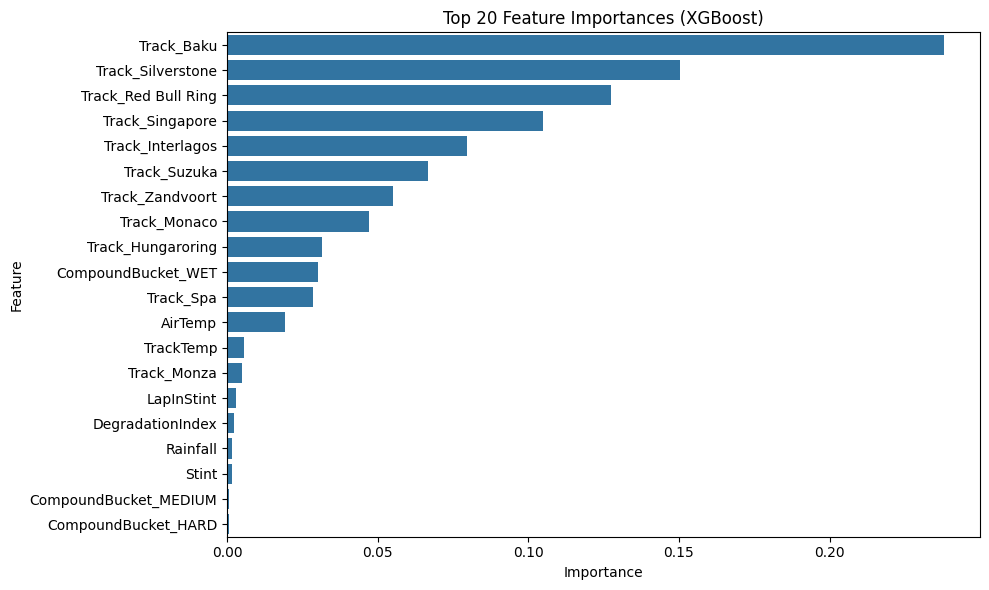

In [195]:
importances = pipeline.named_steps["regressor"].feature_importances_

# Build a DataFrame
feat_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_df.head(20)) 
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()
